[HOG] Estrazione in corso...
[HOG] Feature vector (dim 8100): [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.      

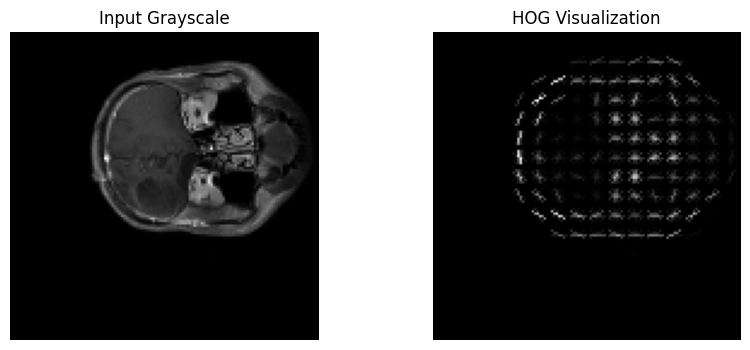

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

# === Funzione: Estrazione HOG ===
def extract_hog_features(img_path):
    print("[HOG] Estrazione in corso...")

    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"[ERRORE] Immagine non trovata: {img_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (128, 128))  # dimensione fissa

    features, hog_image = hog(resized,
                              orientations=9,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2),
                              visualize=True,
                              block_norm='L2-Hys')

    print(f"[HOG] Feature vector (dim {features.shape[0]}): {features[:900]}")

    # Visualizzazione
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.imshow(resized, cmap='gray')
    plt.title("Input Grayscale")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap='gray')
    plt.title("HOG Visualization")
    plt.axis("off")
    plt.show()

    return features

# === Percorso immagine ===
img_path = "Part1/brain_glioma/brain_glioma_0001.jpg"
features = extract_hog_features(img_path)

Seconda implementazione

In [ ]:
import torch
import torchvision.transforms as T
from torchvision.io import read_image
from torchvision.transforms import functional as F
import numpy as np
from matplotlib import pyplot as plt

def visualize_image(image_path):
    """
    Loads and displays an image.

    Args:
        image_path (str): Path to the image file.
    """
    image = read_image(image_path)  # Load the image using torchvision
    plt.imshow(F.to_pil_image(image))
    plt.title("Image")
    plt.show()

def calculate_hog_features(image_path):
    """
    Calculates Histogram of Oriented Gradients (HOG) features for a given image.

    Args:
        image_path (str): Path to the image file.

    Returns:
        numpy.ndarray: 900-dimensional HOG feature descriptor.
    """

    # 1. Load and Preprocess Image
    image = read_image(image_path)
    pil_image = F.to_pil_image(image)  # Convert tensor to PIL Image
    gray_image = F.to_grayscale(pil_image)  # Convert to grayscale
    resized_image = F.resize(gray_image, [300, 10])  # Resize to 300x10
    resized_image = F.to_tensor(resized_image) # Convert back to tensor

    # 2. Calculate Gradients
    #   Using [-1, 0, 1] and [-1, 0, 1].T masks for dI/dx and dI/dy
    dx_filter = torch.tensor([[-1.0, 0.0, 1.0]])
    dy_filter = torch.transpose(dx_filter, 0, 1)

    # Add a channel dimension to resized_image for convolution
    resized_image = resized_image.unsqueeze(0).float()
    dx = torch.conv2d(resized_image, dx_filter.float().unsqueeze(0).unsqueeze(0), padding='same')
    dy = torch.conv2d(resized_image, dy_filter.float().unsqueeze(0).unsqueeze(0), padding='same')

    # Calculate magnitude and orientation
    magnitude = torch.sqrt(dx**2 + dy**2)
    orientation = torch.atan2(dy, dx) * (180 / np.pi)  # Convert radians to degrees

    # 3. Compute Histograms
    cell_size = (30, 1)  # Cell size for the 10x10 grid (300/10, 10/1)
    num_bins = 9  # 9 bins for the histogram (40 degrees per bin)
    histograms = []

    for i in range(0, resized_image.shape[2], cell_size[0]):  # Iterate over rows (height)
        for j in range(0, resized_image.shape[3], cell_size[1]):  # Iterate over columns (width)
            cell_magnitude = magnitude[:, :, i:i + cell_size[0], j:j + cell_size[1]]
            cell_orientation = orientation[:, :, i:i + cell_size[0], j:j + cell_size[1]]

            histogram = torch.zeros(num_bins)
            for bin in range(num_bins):
                # Calculate bin edges
                lower_bound = -90 + bin * 40
                upper_bound = -90 + (bin + 1) * 40

                # Count pixels within the bin
                in_range = (cell_orientation >= lower_bound) & (cell_orientation < upper_bound)
                histogram[bin] = cell_magnitude[in_range].sum()

            histograms.append(histogram)

    # 4.  Concatenate Histograms
    hog_features = torch.cat(histograms).numpy()

    return hog_features

def print_hog_features(hog_features):
    """
    Prints the HOG feature descriptor in a human-readable format.

    Args:
        hog_features (numpy.ndarray): The 900-dimensional HOG feature vector.
    """

    print("HOG Feature Descriptor:")
    print(hog_features)
    print(f"Shape: {hog_features.shape}")  # Ensure it's 900

if __name__ == '__main__':
    image_file = "Part1/brain_glioma/brain_glioma_0001.jpg"  # Replace with the actual path to your image
    visualize_image(image_file)
    hog_features = calculate_hog_features(image_file)
    print_hog_features(hog_features)

Task 2 : 

In [10]:
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
import os

# === Funzione: Estrazione HOG ===
def extract_hog_features_from_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"[ERRORE] Immagine non trovata o non valida: {img_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (128, 128))  # dimensione standard

    features, _ = hog(resized,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=True,
                      block_norm='L2-Hys')
    return features

# === Funzione: Elaborazione immagini in più sottocartelle ===
def process_multiple_folders_for_hog(base_folder, subfolders):
    image_features = []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        print(f"[INFO] Elaboro cartella: {label}")

        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                print(f"  - Immagine: {filename}")
                features = extract_hog_features_from_image(img_path)
                if features is not None:
                    image_features.append({
                        "filename": filename,
                        "label": label,
                        "features": features
                    })

    return image_features

# === Esecuzione ===
base_folder = "Part1"
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]
image_features = process_multiple_folders_for_hog(base_folder, subfolders)

# === Salvataggio CSV ===
df = pd.DataFrame([{
    "filename": entry["filename"],
    **{f"f{i}": val for i, val in enumerate(entry["features"])}
} for entry in image_features])

df.to_csv("hog_features_all.csv", index=False)
print("[SALVATO] Dati HOG salvati in hog_features_all.csv")
print(f"[FINE] Elaborate {len(image_features)} immagini da {len(subfolders)} classi.")


[INFO] Elaboro cartella: brain_glioma
  - Immagine: brain_glioma_0001.jpg
  - Immagine: brain_glioma_0002.jpg
  - Immagine: brain_glioma_0003.jpg
  - Immagine: brain_glioma_0004.jpg
  - Immagine: brain_glioma_0005.jpg
  - Immagine: brain_glioma_0006.jpg
  - Immagine: brain_glioma_0007.jpg
  - Immagine: brain_glioma_0008.jpg
  - Immagine: brain_glioma_0009.jpg
  - Immagine: brain_glioma_0010.jpg
  - Immagine: brain_glioma_0011.jpg
  - Immagine: brain_glioma_0012.jpg
  - Immagine: brain_glioma_0013.jpg
  - Immagine: brain_glioma_0014.jpg
  - Immagine: brain_glioma_0015.jpg
  - Immagine: brain_glioma_0016.jpg
  - Immagine: brain_glioma_0017.jpg
  - Immagine: brain_glioma_0018.jpg
  - Immagine: brain_glioma_0019.jpg
  - Immagine: brain_glioma_0020.jpg
  - Immagine: brain_glioma_0021.jpg
  - Immagine: brain_glioma_0022.jpg
  - Immagine: brain_glioma_0023.jpg
  - Immagine: brain_glioma_0024.jpg
  - Immagine: brain_glioma_0025.jpg
  - Immagine: brain_glioma_0026.jpg
  - Immagine: brain_glioma

In [4]:
import cv2
import numpy as np
import os
from skimage.feature import hog

# === Funzione: Estrazione HOG ===
def extract_hog_features_from_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"[ERRORE] Immagine non trovata o non valida: {img_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (128, 128))  # dimensione standard

    features, _ = hog(resized,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=True,
                      block_norm='L2-Hys')
    return features

# === Funzione: Elaborazione immagini in più sottocartelle ===
def process_multiple_folders_for_hog(base_folder, subfolders):
    all_features = []
    all_filenames = []
    all_labels = []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        print(f"[INFO] Elaboro cartella: {label}")

        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                print(f"  - Immagine: {filename}")
                features = extract_hog_features_from_image(img_path)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)

    return np.array(all_features), np.array(all_filenames), np.array(all_labels)

# === Esecuzione ===
base_folder = "Part1"
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]
features, filenames, labels = process_multiple_folders_for_hog(base_folder, subfolders)

# === Salvataggio in .npz ===
np.savez("hog_features_all.npz", features=features, filenames=filenames, labels=labels)
print("[SALVATO] Dati HOG salvati in hog_features_all.npz")
print(f"[FINE] Elaborate {len(filenames)} immagini da {len(subfolders)} classi.")


[INFO] Elaboro cartella: brain_glioma
  - Immagine: brain_glioma_0001.jpg
  - Immagine: brain_glioma_0002.jpg
  - Immagine: brain_glioma_0003.jpg
  - Immagine: brain_glioma_0004.jpg
  - Immagine: brain_glioma_0005.jpg
  - Immagine: brain_glioma_0006.jpg
  - Immagine: brain_glioma_0007.jpg
  - Immagine: brain_glioma_0008.jpg
  - Immagine: brain_glioma_0009.jpg
  - Immagine: brain_glioma_0010.jpg
  - Immagine: brain_glioma_0011.jpg
  - Immagine: brain_glioma_0012.jpg
  - Immagine: brain_glioma_0013.jpg
  - Immagine: brain_glioma_0014.jpg
  - Immagine: brain_glioma_0015.jpg
  - Immagine: brain_glioma_0016.jpg
  - Immagine: brain_glioma_0017.jpg
  - Immagine: brain_glioma_0018.jpg
  - Immagine: brain_glioma_0019.jpg
  - Immagine: brain_glioma_0020.jpg
  - Immagine: brain_glioma_0021.jpg
  - Immagine: brain_glioma_0022.jpg
  - Immagine: brain_glioma_0023.jpg
  - Immagine: brain_glioma_0024.jpg
  - Immagine: brain_glioma_0025.jpg
  - Immagine: brain_glioma_0026.jpg
  - Immagine: brain_glioma

Task 3

Distanza coseno:

[RISULTATI] Le 11 immagini più simili a 'brain_glioma_0001.jpg':
- brain_glioma_0001.jpg (similarità: 1.0000)
- brain_glioma_0959.jpg (similarità: 0.6202)
- brain_glioma_0102.jpg (similarità: 0.6165)
- brain_glioma_0633.jpg (similarità: 0.6143)
- brain_menin_0454.jpg (similarità: 0.5983)
- brain_glioma_0918.jpg (similarità: 0.5884)
- brain_glioma_0480.jpg (similarità: 0.5856)
- brain_glioma_0820.jpg (similarità: 0.5814)
- brain_glioma_0377.jpg (similarità: 0.5698)
- brain_glioma_0032.jpg (similarità: 0.5665)
- brain_glioma_0496.jpg (similarità: 0.5640)


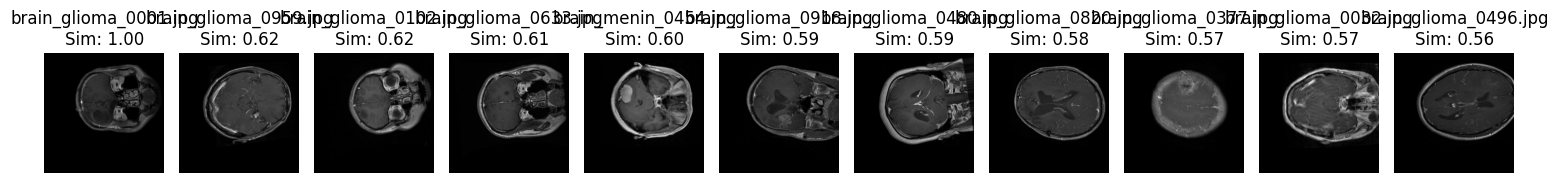

In [13]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.metrics.pairwise import cosine_similarity

# === Funzione: Estrai feature HOG dalla query ===
def extract_hog_features(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"[ERRORE] Immagine non trovata o non valida: {img_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (128, 128))
    features, _ = hog(resized,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=True,
                      block_norm='L2-Hys')
    return features

# === Funzione: Visualizza immagini simili ===
def show_similar_images(results, base_folder):
    fig, axes = plt.subplots(1, len(results), figsize=(15, 5))
    if len(results) == 1:
        axes = [axes]
    for ax, (filename, score) in zip(axes, results):
        img_path = None
        # Cerca nei sottocartelle
        for subdir in os.listdir(base_folder):
            candidate_path = os.path.join(base_folder, subdir, filename)
            if os.path.exists(candidate_path):
                img_path = candidate_path
                break
        if img_path:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(f"{filename}\nSim: {score:.2f}")
            ax.axis('off')
        else:
            ax.set_title(f"Non trovata: {filename}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# === Funzione principale ===
def find_similar_images_npz(query_path, k, npz_path="hog_features_all.npz", base_folder="Part1"):
    # Carica i dati dal file .npz
    data = np.load(npz_path, allow_pickle=True)
    X = data["features"]
    filenames = data["filenames"]

    # Estrai le feature dalla query
    query_features = extract_hog_features(query_path)
    if query_features is None:
        print("[ERRORE] Impossibile estrarre feature dalla query.")
        return

    # Calcola la similarità coseno
    similarities = cosine_similarity([query_features], X)[0]

    # Ordina per similarità decrescente
    sorted_indices = np.argsort(similarities)[::-1]
    top_k = sorted_indices[:k]

    results = [(filenames[i], similarities[i]) for i in top_k]

    print(f"[RISULTATI] Le {k} immagini più simili a '{os.path.basename(query_path)}':")
    for fname, score in results:
        print(f"- {fname} (similarità: {score:.4f})")

    show_similar_images(results, base_folder)

# === ESEMPIO DI USO ===
query_image = "Part1/brain_glioma/brain_glioma_0001.jpg"
k = 11
find_similar_images_npz(query_image, k)


Distanza euclidea:

[RISULTATI] Le 11 immagini più simili a 'brain_glioma_0001.jpg':
- brain_glioma_0001.jpg (distanza: 0.0000)
- brain_glioma_0959.jpg (distanza: 10.9959)
- brain_glioma_0377.jpg (distanza: 11.3684)
- brain_glioma_0480.jpg (distanza: 11.4592)
- brain_glioma_0820.jpg (distanza: 11.5366)
- brain_menin_0454.jpg (distanza: 11.5895)
- brain_glioma_0201.jpg (distanza: 11.6265)
- brain_glioma_0633.jpg (distanza: 11.6492)
- brain_glioma_0102.jpg (distanza: 11.6996)
- brain_glioma_0918.jpg (distanza: 11.7283)
- brain_glioma_0496.jpg (distanza: 11.7303)


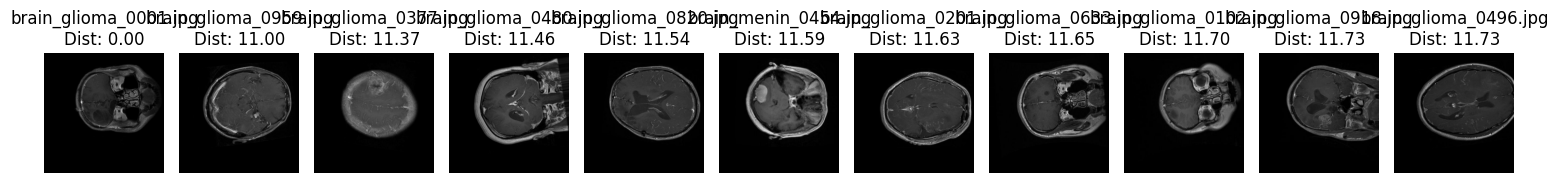

In [12]:
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.metrics.pairwise import euclidean_distances
import os
import matplotlib.pyplot as plt

# === Funzione: Estrai feature HOG ===
def extract_hog_features(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"[ERRORE] Immagine non trovata o non valida: {img_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (128, 128))
    features, _ = hog(resized,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=True,
                      block_norm='L2-Hys')
    return features

# === Funzione: Visualizza immagini simili ===
def show_similar_images(results, base_folder):
    fig, axes = plt.subplots(1, len(results), figsize=(15, 5))
    if len(results) == 1:
        axes = [axes]
    for ax, (filename, dist) in zip(axes, results):
        img_path = None
        for subdir in os.listdir(base_folder):
            candidate_path = os.path.join(base_folder, subdir, filename)
            if os.path.exists(candidate_path):
                img_path = candidate_path
                break
        if img_path:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(f"{filename}\nDist: {dist:.2f}")
            ax.axis('off')
        else:
            ax.set_title(f"Non trovata: {filename}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# === Funzione principale ===
def find_similar_images_npz(query_path, k, npz_path="hog_features_all.npz", base_folder="Part1"):
    # Carica i dati dal file .npz
    data = np.load(npz_path, allow_pickle=True)
    X = data['features']
    filenames = data['filenames']

    # Estrai feature della query
    query_features = extract_hog_features(query_path)
    if query_features is None:
        print("[ERRORE] Impossibile estrarre feature dalla query.")
        return

    # Calcola distanza euclidea
    distances = euclidean_distances([query_features], X)[0]

    # Ordina per distanza crescente
    sorted_indices = np.argsort(distances)
    top_k = sorted_indices[:k]

    results = [(filenames[i], distances[i]) for i in top_k]

    print(f"[RISULTATI] Le {k} immagini più simili a '{os.path.basename(query_path)}':")
    for fname, dist in results:
        print(f"- {fname} (distanza: {dist:.4f})")

    show_similar_images(results, base_folder)

# === Esempio di utilizzo ===
query_image = "Part1/brain_glioma/brain_glioma_0001.jpg"
k = 11
find_similar_images_npz(query_image, k)


[RISULTATI - cosine] Le 5 immagini più simili a 'brain_menin_0011.jpg':
- brain_menin_0011.jpg (score: 1.0000)
- brain_glioma_0406.jpg (score: 0.7505)
- brain_menin_0157.jpg (score: 0.7461)
- brain_menin_0607.jpg (score: 0.7455)
- brain_menin_0452.jpg (score: 0.7294)


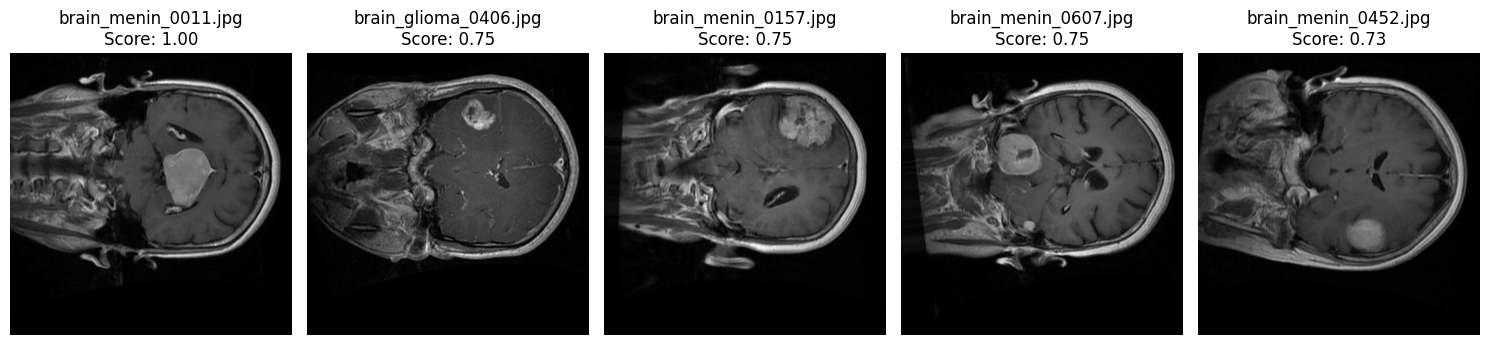

In [23]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

# === Funzione: Estrai feature HOG ===
def extract_hog_features(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"[ERRORE] Immagine non trovata o non valida: {img_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (128, 128))
    features, _ = hog(resized,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=True,
                      block_norm='L2-Hys')
    return features

# === Distanza Chi-Squared ===
def chi2_distance(a, b, eps=1e-10):
    return 0.5 * np.sum(((a - b) ** 2) / (a + b + eps))

# === Similarità Correlazione ===
def correlation_similarity(a, B):
    a_mean = a - np.mean(a)
    B_mean = B - np.mean(B, axis=1, keepdims=True)
    num = np.dot(B_mean, a_mean)
    denom = np.linalg.norm(B_mean, axis=1) * np.linalg.norm(a_mean)
    return num / (denom + 1e-10)

# === Visualizza immagini ===
def show_similar_images(results, base_folder):
    fig, axes = plt.subplots(1, len(results), figsize=(15, 5))
    if len(results) == 1:
        axes = [axes]
    for ax, (filename, score) in zip(axes, results):
        img_path = None
        for subdir in os.listdir(base_folder):
            candidate_path = os.path.join(base_folder, subdir, filename)
            if os.path.exists(candidate_path):
                img_path = candidate_path
                break
        if img_path:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(f"{filename}\nScore: {score:.2f}")
            ax.axis('off')
        else:
            ax.set_title(f"Non trovata: {filename}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# === Trova immagini simili ===
def find_similar_images_npz(query_path, k, npz_path="hog_features_all.npz", base_folder="Part1", metric="cosine"):
    data = np.load(npz_path, allow_pickle=True)
    X = data["features"]
    filenames = data["filenames"]

    query_features = extract_hog_features(query_path)
    if query_features is None:
        print("[ERRORE] Impossibile estrarre feature dalla query.")
        return

    # === Calcolo distanza/similarità ===
    if metric == "cosine":
        similarities = cosine_similarity([query_features], X)[0]
        sorted_indices = np.argsort(similarities)[::-1]  # similarità -> decrescente
        results = [(filenames[i], similarities[i]) for i in sorted_indices[:k]]
    elif metric == "euclidean":
        distances = euclidean_distances([query_features], X)[0]
        sorted_indices = np.argsort(distances)  # distanza -> crescente
        results = [(filenames[i], distances[i]) for i in sorted_indices[:k]]
    elif metric == "manhattan":
        distances = manhattan_distances([query_features], X)[0]
        sorted_indices = np.argsort(distances)
        results = [(filenames[i], distances[i]) for i in sorted_indices[:k]]
    elif metric == "chi2":
        distances = np.array([chi2_distance(query_features, x) for x in X])
        sorted_indices = np.argsort(distances)
        results = [(filenames[i], distances[i]) for i in sorted_indices[:k]]
    elif metric == "correlation":
        similarities = correlation_similarity(query_features, X)
        sorted_indices = np.argsort(similarities)[::-1]
        results = [(filenames[i], similarities[i]) for i in sorted_indices[:k]]
    else:
        print(f"[ERRORE] Metrica non supportata: {metric}")
        return

    print(f"[RISULTATI - {metric}] Le {k} immagini più simili a '{os.path.basename(query_path)}':")
    for fname, score in results:
        print(f"- {fname} (score: {score:.4f})")

    show_similar_images(results, base_folder)

# === Esempio di uso ===
query_image = "Part1/brain_menin/brain_menin_0011.jpg"
k = 5
find_similar_images_npz(query_image, k, metric="cosine")  # Cambia qui per provare cosine, euclidean, etc.
